**Import Statements**

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

**Loading the Data**

In [64]:
data = pd.read_csv('/content/AAPL.csv')

In [65]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600


In [66]:
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

<ipython-input-66-975dad9f7220>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


**Visualize of Close Price**

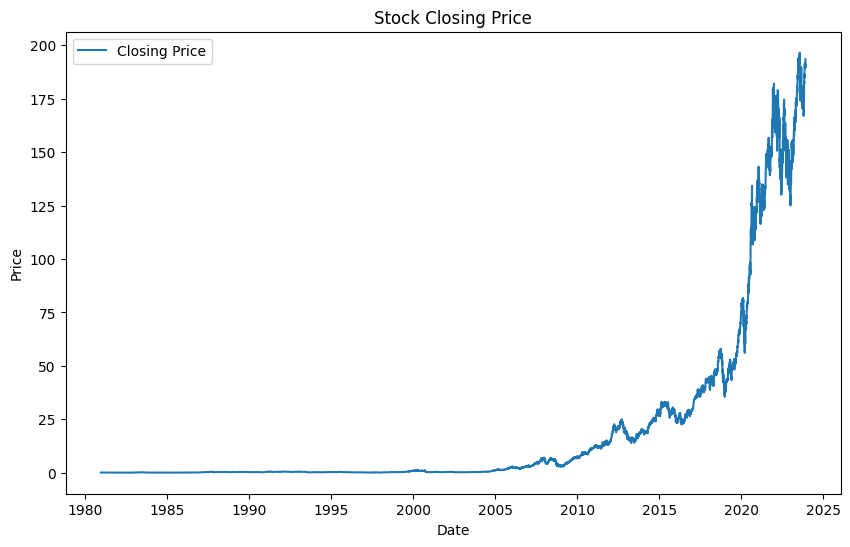

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Closing Price')
plt.title('Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Pre Processing**

In [68]:
data_values = data['Close'].values.reshape(-1, 1)

In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_values)

**Data Preparation of LSTM**

In [70]:
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i, 0])
    y.append(data_scaled[i, 0])

In [71]:
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

**Split the Data for Training & Testing**

In [72]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

**LSTM Model**

In [73]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile the Model**

In [74]:
model.compile(optimizer='adam', loss='mean_squared_error')

**Train the Model**

In [75]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - loss: 1.6115e-04 - val_loss: 0.0022
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 1.7533e-05 - val_loss: 6.4520e-04
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 39s 69ms/step - loss: 1.4686e-05 - val_loss: 6.0860e-04
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - loss: 1.3311e-05 - val_loss: 0.0016
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 1.6029e-05 - val_loss: 6.2081e-04
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 1.3594e-05 - val_loss: 4.4693e-04
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 1.2589e-05 - val_loss: 6.3201e-04
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 1.4109e-05 - val_loss: 3.1805e-04
Epoch 9/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 1.4183e-05 - val_loss: 5.7950e-04
Epoch 10/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 1.1946e-05 - val_loss: 0.0032
Epoch 11/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/s

**Evalution of Model**

In [76]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


**Actual vs Predicted**

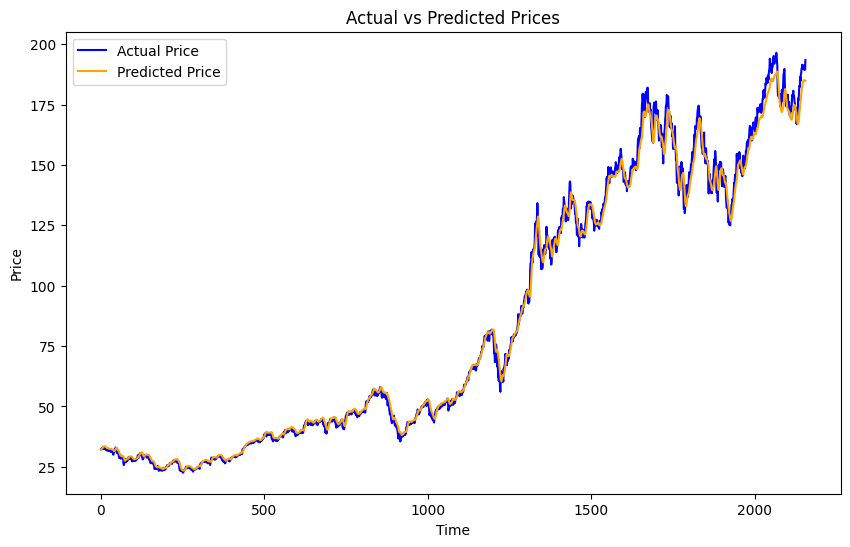

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**Root Mean Square Error**

In [78]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 3.3503948918057262
